# [LAB12] 5. 로지스틱 회귀 (이항 분류)

### 로지스틱 회귀의 이해
- 종속 변수가 범주형인 변수에 대한 회귀 분석
- 여러개의 값을 갖는 명목형 종속 변수에도 적용 가능
- 어떤 사건이 발생할 확률을 예측하는 것


### 로지스틱 회귀 모형
- 종속 변수가 범주형 자료이며, 선형모형의 특수한 경우로 s 형 곡선을 그리는 함수 모형
  (종속 변수 : 이분형 / 독립변수 : 범주형, 연속형)


분석 결과 종속변수 값, 즉 확률이 0.5보다 크면 그 사건이 일어나며, 0.5보다 작으면 그 사건이 일어나지 않을 것으로 예측



### 로지스틱의 가정
- 로지스틱 회귀분석은 판별 분석에서 사용하는 동일한 개념의 분포 가정을 따르지 않는다
- 그러나 독립변수가 다변량 정규 분포를 따른다면 현재 해법이 좀 더 안정적으로 적용될 수 있다
- 다른 형식의 회귀분석에서처럼 예측 변수 간의 다중공선성은 편향된 추정값과 팽장된 표준 오차를 유도할 수 있다



### #01. 준비 작업

In [1]:
# 라이브러리 기본 참조
from hossam import load_data
from pandas import DataFrame, get_dummies
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

# 로지스틱을 위한 참조
import statsmodels.api as sm

# 로지스틱 결과 판별을 위한 참조
# → 머신러닝 라이브러리를 미리 사용
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score
)


### 2. 그래프 초기화

In [2]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

3. 데이터 가져오기

In [3]:
origin = load_data('graduate')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())

origin.head()


[data] https://data.hossam.kr/data/lab12_/graduate.xlsx
[desc] 방사선학 석사과정 대학원생 모집 현황을 조사한 가상의 데이터
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (400, 4)
열 개수: 4
행 개수: 400

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   합격여부    400 non-null    int64  
 1   필기점수    400 non-null    int64  
 2   학부성적    400 non-null    float64
 3   병원경력    400 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 12.6+ KB
None


,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,1~5년
1,1,660,3.67,1~5년
2,1,800,4.00,10년 이상
3,1,640,3.19,1년 미만
4,0,520,2.93,1년 미만


### #02. 데이터 전처리

#### 1. 병원 경력의 종류 확인

In [4]:
origin['병원경력'].unique()

array(['1~5년', '10년 이상', '1년 미만', '5~10년'], dtype=object)

2. 명목형 변수의 전처리
- 데이터 라벨링: 값의 종류별로 0,1,2, 등의 숫자 체계로 변환.
   - 라벨링 후 탐색적 데이터 분석을 위해서는 category 타입으로 바꾸는게 유리함
   - 그래야 EDA 할 떄 명목형 변수에 수치 계산적용이 안된다

In [6]:
df = origin.copy()
df['병원경력'] = df['병원경력'].map({
    '1년 미만' : 0 , '1~5년' :1 , '5~10년':2 , '10년 이상' :3
  
})


df['병원경력'].unique()

array([1, 3, 0, 2])

- 명목형 변수의 더미변수 처리 (one hot encoding)


In [8]:
df2 = get_dummies(df,columns=['병원경력'] , dtype ='int',drop_first = True)

df2.head()

,합격여부,필기점수,학부성적,병원경력_1,병원경력_2,병원경력_3
0,0,380,3.61,1,0,0
1,1,660,3.67,1,0,0
2,1,800,4.00,0,0,1
3,1,640,3.19,0,0,0
4,0,520,2.93,0,0,0


### #03.로지스틱 회귀분석
#### 1. 로지스틱 수행

In [ ]:
#

,const,필기점수,학부성적,병원경력_1,병원경력_2,병원경력_3
0,1.0,380,3.61,1,0,0
1,1.0,660,3.67,1,0,0
2,1.0,800,4.00,0,0,1
3,1.0,640,3.19,0,0,0
4,1.0,520,2.93,0,0,0
...,...,...,...,...,...,...
395,1.0,620,4.00,0,1,0
396,1.0,560,3.04,1,0,0
397,1.0,460,2.63,0,1,0
398,1.0,700,3.65,0,1,0


Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   합격여부   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Mon, 15 Dec 2025   Pseudo R-squ.:                 0.08292
Time:                        14:52:25   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 7.578e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5414      1.138     -4.869      0.000      -7.772      -3.311
필기점수           0.0023      0.

### #03.이진분류의 평가
#### 1.혼동행렬
| 구분 | 예시 |
|---|---|
| TN (True Negative, Negative Negative) | 실제는 임신이 아니고(0), 임신이 아닌 것(0)으로 잘 예측함 |
| FP (False Positive, Negative Positive) | 실제는 임신이 아닌데(0), 임신(1)으로 예측함 (Type 1 Error) |
| FN (False Negative, Positive Negative) | 실제는 임신인데(1), 임신이 아닌 것(0)으로 예측함 (Type 2 Error) |
| TP (True Positive, Positive Positive) | 실제는 임신인데(1), 임신(1)으로 잘 예측함 |


#### 2.혼동행렬 구하기
- 실제 종속변수

In [10]:
y_true = df2['합격여부']
y_true

0      0
1      1
2      1
3      1
4      0
      ..
395    0
396    0
397    0
398    0
399    0
Name: 합격여부, Length: 400, dtype: int64

- 로지스틱이 예측한 값 (1일 확률을 의미함)

In [11]:
y_pred = fit.predict(x_input)
y_pred

0      0.172627
1      0.292175
2      0.738408
3      0.178385
4      0.118354
         ...   
395    0.488670
396    0.165504
397    0.181062
398    0.463667
399    0.300731
Length: 400, dtype: float64

- 혼동행렬 구하기 위해 예측 결과를 이진값으로 변환
  50% 초과인 경우 True , 그렇지 않을 경우 False 로 변환

In [12]:
y_pred_fix = y_pred >0.5
y_pred_fix

0      False
1      False
2       True
3      False
4      False
       ...  
395    False
396    False
397    False
398    False
399    False
Length: 400, dtype: bool

- 혼동 행렬
  

In [13]:
cm = confusion_matrix(y_true , y_pred_fix)
tn , fp , fn , tp = cm.ravel()
tn , fp, fn , tp

(np.int64(254), np.int64(19), np.int64(97), np.int64(30))

- 혼동행렬을 DataFrame 으로 변환

In [14]:
cmdf = DataFrame (cm,index =['Actual 0 (TN/FP)' , 'Actual 1 (FN/TP)'] , columns = ['Predicted (Negative)' , 'Predicted (Positice)'])


cmdf

,Predicted (Negative),Predicted (Positice)
Actual 0 (TN/FP),254,19
Actual 1 (FN/TP),97,30


- 혼동행렬 히트맵

In [ ]:
# 1) 그래프 초기화
width_px  = 500   # 그래프 가로 크기
height_px = 400   # 그래프 세로 크기
rows = 1          # 그래프 행 수
cols = 1          # 그래프 열 수

figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) heatmap 그리기
sb.heatmap(
    data=cmdf,
    annot=True,
    fmt="0.1f",
    linewidth=0.5,
    cmap="PuOr"
)

# 3) 그래프 꾸미기
ax.set_xlabel("")
ax.set_ylabel("")
ax.xaxis.tick_top()   # x축의 변수 이름을 상단으로 이동

# 4) 출력
plt.tight_layout()    # 여백 제거
plt.show()            # 그래프 화면 출력
plt.close()           # 그래프 작업 종료


#### 3. 정확도 (Accuracy)
- 전체 데이터 (fp +fn +tp+tn) 중에서 제대로 판정한 데이터 (tp+tn) 의 비율
- $$Accuracy = \frac{정확히~예측한~데이터~수}{전체~데이터~수} = \frac{TN+TP}{TN+FP+FN+TP}$$

<직접 계산으로 구하기>

In [16]:
(tn+tp)/(tn+fp+fn+tp)

np.float64(0.71)

<함수로 구하기>

In [18]:
acc=accuracy_score(y_true , y_pred_fix)
acc

0.71

#### 4. 정밀도 (Precision)
양성으로 예측한 데이터 중 관측치도 양성으로 예측한 비율



  $$Precision = \frac{예측과~실제~값이~Positive로~일치하는~것들}{Positive로 예측한~전체~개수} = \frac{TP}{FTP}$$

In [19]:
#PRE = TP / (FP+TP)
pre = precision_score(y_true,y_pred_fix)
pre

0.6122448979591837

5. 재현율(Recall, TPR)
   실제로 양성인 관측치 중에서 양성으로 예측한 비율
   TPR(True Positive Rate) 또는 민감도 (sensitivity) 라고도 한다
$$
\text{TPR}
= \frac{\text{실제 Positive 중 Positive로 맞춘 개수}}
       {\text{실제 Positive 전체 개수}}
= \frac{TP}{TP + FN}
$$


In [25]:
recall = tp/(tp+fn)
recall = recall_score(y_true, y_pred_fix)
recall

0.23622047244094488

6. 위양성율 (거짓 양성 비율) =Fallout , FPR
실제로는 음성인 관측치 중에서 양성으로 예측한 비율
FPR (False Positice Rate 이라고도 한다)

$$
\text{FPR}
= \frac{\text{실제 Negative 중 Positive로 잘못 예측한 개수}}
       {\text{실제 Negative 전체 개수}}
= \frac{FP}{FP + TN}
$$


In [20]:
fpr = fp / (fp+tn)

fpr

np.float64(0.0695970695970696)

7. 특이성 (Specificity, TNR , True Negative Rate)
   1에서 위양성률의 값을 뺸 값으로 실제 값 Negative 가 정확히 예측되어야 하는 수준을 의미한다
$$
\text{TNR}
= 1 - \text{FPR}
= \frac{\text{Negative를 올바르게 예측한 개수}}
       {\text{실제 Negative인 것들}}
= \frac{TN}{TN + FP}
$$


In [21]:
tnr = 1-fpr
tnr

np.float64(0.9304029304029304)

8. F1 Score
   Precision 과 Recall 의 조화 평균
   정밀도와 재현율을 결한한 지표이다 (양성 예측도와 민감도)
   정밀도와 재현율이 어느 한 쪾으로 치우치지 않을 때 상대적으로 높은 값을 가진다

$$
\text{F1}
= 2 \times \frac{\text{Precision} \times \text{Recall}}
{\text{Precision} + \text{Recall}}
= \frac{2TP}{2TP + FP + FN}
$$



In [22]:
#f1 = 2*((pre*Recall)) / (pre+recall)
f1 = f1_score(y_true, y_pred_fix)
f1

0.3409090909090909

9. 정리

| 지표 | 의미 | 기준(분모) | 핵심 특징 | 언제 사용해야 하는가 |
|---|---|---|---|---|
| Accuracy | 전체 데이터 중 올바르게 분류한 비율 | 전체 데이터 | 직관적이나 클래스 불균형에 취약 | 클래스가 균형이고 FP·FN의 중요도가 비슷할 때 |
| Precision | Positive로 예측한 것 중 실제 Positive 비율 | 예측 Positive | FP에 민감, 보수적 판단 지표 | **FP가 치명적인 경우** (스팸 필터, 추천 시스템) |
| TPR (Recall) | 실제 Positive를 얼마나 놓치지 않았는가 | 실제 Positive | FN에 민감, 탐지 성능 지표 | **FN이 치명적인 경우** (의료 진단, 이상 탐지) |
| FPR | 실제 Negative를 Positive로 잘못 판단한 비율 | 실제 Negative | 오경보 정도를 나타냄 | 오경보 비용을 관리해야 할 때 (보안, 경보 시스템) |
| TNR (Specificity) | 실제 Negative를 정확히 걸러낸 비율 | 실제 Negative | FPR의 보완 지표 | 정상군 판별이 중요한 경우 |
| F1 Score | Precision과 Recall을 균형 있게 반영한 지표 | Precision & Recall | TN을 고려하지 않음, 불균형 데이터에 강함 | 클래스 불균형 + **FP·FN 모두 중요한 경우** |


10. ROC Curve
    재현율과 (recall) 과 위 양성률(fall_out) 은 일반적으로 양의 상관관계가 있다.
    ROC Curve 는 클래스 판별 기준값의 변화에 따른 위양성률과 재현율의 변화를 시각화한 것이다
    위양성율 (FPR) 을 X 축으로, 재현율을 (TPR) Y축으로 잡은 그래프 

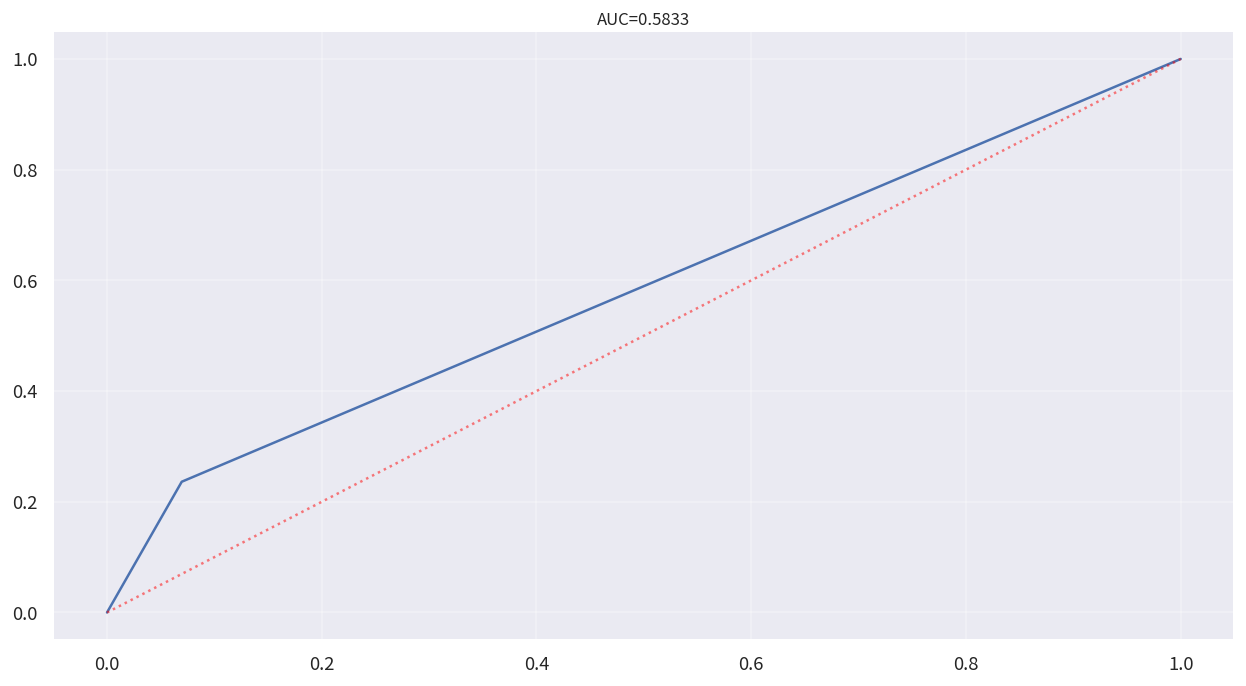

In [23]:
ras = roc_auc_score(y_true, y_pred_fix)
0

roc_fpr , roc_tpr ,thresholds = roc_curve(y_true, y_pred_fix)


# 1) 그래프 초기화
width_px = 1280          # 그래프 가로 크기
height_px = 720          # 그래프 세로 크기
rows = 1                 # 그래프 행 수
cols = 1                 # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) LinePlot 그리기
sb.lineplot(x=roc_fpr, y=roc_tpr)
sb.lineplot(x=[0, 1], y=[0, 1], color='red', linestyle=':', alpha=0.5)

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)          # 배경 격자 표시
ax.set_title(f'AUC={ras:.4f}', fontsize=10, pad=4)

# 4) 출력
plt.tight_layout()     # 여백 제거
plt.show()             # 그래프 화면 출력
plt.close()            # 그래프 작업 종료


가운데 직선은 ROC 곡선의 최저값으로 ROC CURVE 가 가운데 직선에 가까울수록 성능이 떨어지고, 멀어질수록 성능이 뛰어나다

ROC Curve 는 FPR 을 0에서 1까지 변화시키면서 TPR의 변화 값을 구한다

- AUC (Area Under Curve)
  ROC 곡선 밑의 면적을 구한 것으로 1에 가까울수록 좋은 수치다
  가운데 직선에서 멀어지고, 왼쪽 상단 모서리 쪽으로 가파르게 곡선이 이동할수록 직사각형에 가까운 곡선이 되어 면적 1에 가까워진다

In [26]:
result_df = DataFrame({
    '설명력(Pseudo-Rsq)': [fit.prsquared],
    '정확도(Accuracy)': [acc],
    '정밀도(Precision)': [pre],
    '재현율(Recall, TPR)': [recall],
    '위양성율(Fallout, FPR)': [fpr],
    '특이성(Specificity, TNR)': [tnr],
    'RAS': [ras],
    'f1_score': [f1]
})

result_df


,설명력(Pseudo-Rsq),정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)","위양성율(Fallout, FPR)","특이성(Specificity, TNR)",RAS,f1_score
0,0.082922,0.71,0.612245,0.23622,0.069597,0.930403,0.583312,0.340909


### #04.Odds Ratio (오즈비, 또는 승산비)
#### Odds (오즈 또는 승산)
- 임의의 이벤트가 어떤 요인에 의해 발생하지 않을 확률 대비 발생할 확률
- 로지스틱 회기분석에서 임의의 설명변수의 추이에 따른 목표변수의 추이를 표현할 때 주로 사용되는 것


$$
\text{Odds} = \frac{\text{이벤트 발생 확률}}{\text{이벤트 미발생 확률}}
= \frac{p}{1 - p}
$$


Odds Ratio (오즈비 또는 승산비)
- Odds Ratio 는 특정 요인의 여부에 따른 이벤트 발생 확률을 비교할때 사용되는 척도
- 말그대로 오즈 간의 비율을 의미
- 오즈비 값의 범위에 따라 독립변수가 종속변수에 영향을 미치는 방향성에 차이가 있다
- 예를 들어 어떤 요인의 노출 여부에 따른 질병 감염률을 오즈비를 통해 계산할 수 있다



| 방향성        | 설명 |
|--------------|------|
| OddsRatio < 1 | x가 증가하면, y가 1이 될 가능성은 낮아진다. |
| OddsRatio > 1 | x가 증가하면, y가 1이 될 가능성은 높아진다. |
| OddsRatio = 1 | x는 y에 영향을 주지 않는다. |


- 오즈비 계산
- ## Odds Ratio (오즈비)

\[
\text{Odds Ratio} 
= \frac{TP / FN}{FP / TN} 
= \frac{TP \times TN}{FP \times FN}
\]

---

## 예시: 약물남용과 탈모의 관계

탈모에 걸린 집단과 그렇지 않은 집단에서 **약물남용 여부**에 따라  
약물남용이 탈모와 연관된 위험요소인지 파악한다.

| 약물남용 (위험 요소) | 탈모 발생 (환자군) | 탈모 미발생 (대조군) |
|--------------------|------------------|------------------|
| Yes                | 79 (TP)          | 19 (FP)          |
| No                 | 152 (FN)         | 178 (TN)         |

---

## Odds Ratio 계산

\[
\text{Odds Ratio} 
= \frac{\text{노출군 Odds}}{\text{비노출군 Odds}}
= \frac{TP / FN}{FP / TN}
= \frac{79 \times 178}{19 \times 152}
= \frac{14062}{2888}
\approx 4.87
\]

👉 **약물남용군은 탈모 발생 오즈가 비약물남용군에 비해 약 4.87배 높다.**

---

## Odds의 의미

오즈(Odds)는  
\[
\text{성공할 확률} \; / \; \text{실패할 확률}
\]
로 정의된다.

이 예제에서는 종속변수가 **합격 여부**라면,

\[
\text{Odds Ratio} = \frac{\text{합격 확률}}{\text{불합격 확률}}
\]

---

## 로지스틱 회귀와 Odds Ratio

- 로지스틱 회귀에서 회귀계수는 **log-odds** 단위
- 계수에 `np.exp()`를 적용하면 **Odds Ratio**로 변환 가능

\[
\text{Odds Ratio} = e^{\beta}
\]

이를 통해 독립변수가 종속변수에 미치는 영향을  
**직관적인 배수 효과**로 해석할 수 있다.


- 계수 추출

In [27]:
coef = fit.params
coef

const    -5.541443
필기점수      0.002264
학부성적      0.804038
병원경력_1    0.211260
병원경력_2    0.876021
병원경력_3    1.551464
dtype: float64

- 오즈 구하기

In [28]:
odds_rate = np.exp(coef)
odds_rate_df = DataFrame(odds_rate , columns =['odds_rate'])
odds_rate_df

,odds_rate
const,0.003921
필기점수,1.002267
학부성적,2.234545
병원경력_1,1.235233
병원경력_2,2.401325
병원경력_3,4.718371


| 변수        | 오즈비 (OR) | 해석                                                                 | 영향 강도 |
|------------|-------------|----------------------------------------------------------------------|-----------|
| const      | 0.003921    | 모든 설명변수가 0일 때의 기준 오즈로, 실질적 해석 대상은 아님        | 기준값    |
| 필기점수   | 1.002267    | 필기점수가 1점 증가할 때 합격 오즈가 약 0.23% 증가                  | 매우 약함 |
| 학부성적   | 2.234545    | 학부성적이 1단위 증가할 때 합격 오즈가 약 2.23배 증가               | 강함      |
| 병원경력_1 | 1.235233    | 병원경력 없음 대비 합격 오즈가 약 1.24배 높음                       | 약함      |
| 병원경력_2 | 2.401325    | 병원경력 없음 대비 합격 오즈가 약 2.40배 높음                       | 강함      |
| 병원경력_3 | 4.718371    | 병원경력 없음 대비 합격 오즈가 약 4.72배 높음                       | 매우 강함 |


해석 요약
10년 이상의 병원경력이 종속변수인 합격 여부에 미치는 영향이 가장 크다고 볼 수 있다.

- 오즈비

In [29]:
odds_ratio = (tp*tn) / (fp*fn)
odds_ratio


np.float64(4.134563212154097)

> 노출군의 사건 발생 오즈는 비노출군에 비해 약 4.13배 높은 것으로 나타났다
> 설명변수가 1 단위 증가할 때 종속변수가 1이될 오즈는 약 4.13배 증가한다

### #05. 가상의 데이터를 통한 예측

In [30]:
myinput = '480,4.3,0,0,1'
myinput = myinput.split(',')


x_new = DataFrame([{
    '필기점수': int(myinput[0].strip()),
    '학부성적': float(myinput[1].strip()),
    '병원경력_1': int(myinput[2].strip()),
    '병원경력_2': int(myinput[3].strip()),
    '병원경력_3': int(myinput[4].strip())
}])

x_new_input = sm.add_constant(x_new, has_constant='add')

myresult = fit.predict(x_new_input)
myresult


0    0.635134
dtype: float64

In [31]:
"당신의 합격 확률은 {0:0.2f}% 입니다".format(myresult[0]*100)

'당신의 합격 확률은 63.51% 입니다'

In [32]:
"합격" if myresult[0] > 0.5 else '불합격'

'합격'